In [1]:
import os
import math
import dicom
import numpy as np
from lxml import etree
from scipy import ndimage
from matplotlib import cm
from matplotlib import pyplot as plt
from qstatistic.qstatistic import qSigmoid

In [2]:
# Load all images directories from a folder to a list.
def loadDirectories(PathDicom="./images/", PathXml="./xml/"):
    lstFile = []
    for dirDicomName, subdirDicomList, fileDicomList in os.walk(PathDicom):
        for filenameDicom in fileDicomList:
            dicom_name = filenameDicom.split('.')[0]
            dicom_ext = filenameDicom.split('.')[1]
            for dirXmlName, subdirXmlList, fileXmlList in os.walk(PathXml):
                for filenameXml in fileXmlList:
                    xml_name = filenameXml.split('.')[0]
                    xml_ext = filenameXml.split('.')[1]

                    if dicom_ext.lower() == 'dcm' and xml_ext.lower() == 'xml' and \
                            dicom_name.split('_')[0] == xml_name:
                        lstFile.append({
                            'dicom': os.path.join(dirDicomName,filenameDicom),
                            'xml': os.path.join(dirXmlName,filenameXml)
                        })

    return lstFile

In [3]:
def readXml(AllFiles):
    result = []
    
    for i in range(len(AllFiles)):
        doc = etree.parse(AllFiles[i].get('xml'))

        rois = doc.find('dict').find('array').find('dict').find('array').findall('dict')

        count = 1
        for r in rois:
            roi_type = r.findall('string')[-1]
            roi_points = r.findall('array')[-1].findall('string')
            if roi_type.text == 'Mass':
                AllFiles[i]['type_'+str(count)] = roi_type.text
                points = []
                for p in roi_points:
                    points.append((round(float(p.text.replace('(', '').replace(')', '').split(', ')[1])),
                                   round(float(p.text.replace('(', '').replace(')', '').split(', ')[0]))))
                AllFiles[i]['points_'+str(count)] = points
                count += 1
                result.append(AllFiles[i])
        
    return result

In [4]:
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0: 
       return v
    return v/norm

In [5]:
def makeSegmentation(image_path):
    # Make qSigmoid with one image from list.
    image_full = dicom.read_file(image_path.get('dicom'))

    #image
    image = image_full.pixel_array

    #image qSigmoid
    L = np.max(image)
    B = 1760
    a = 110
    q = 0.35

    image_qSigmoid = qSigmoid(L=L, I=image, B=B, a=a, q=q).calc()
    
    image_xml = np.zeros(image.shape)
    
    points = image_path.get('points_1')
    for p in points:
        image_xml[p] = 1    
        
        
    open_close_size = (5,5)

    im = normalize(image_qSigmoid)
    lin, col = im.shape

    mask = (im > im.mean()).astype(np.float)

    binary_img = mask > 0.5

    # Remove small white regions
    open_img = ndimage.binary_opening(binary_img, structure=np.ones(open_close_size))

    # Remove small black hole
    close_img = ndimage.binary_closing(open_img, structure=np.ones(open_close_size))
    
    return [image, image_xml, close_img, image_qSigmoid]

In [6]:
def plotSegmentation(image, image_xml, image_morph, image_qSigmoid):
    plt.figure(figsize=(18, 12))

    plt.subplot(231)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title('Original')

    # plt.subplot(232)
    # plt.imshow(image_xml, cmap=plt.cm.gray)
    # plt.title('XML')

    plt.subplot(233)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.contour(image_xml, [0.5], linewidths=1, colors='r')
    plt.title('XML Contoured')

    plt.subplot(234)
    plt.imshow(image_qSigmoid, cmap=plt.cm.gray)
    plt.title('qSigmoid')

    plt.subplot(235)
    plt.imshow(image_morph, cmap=plt.cm.gray)
    plt.title('qSigmoid After Morphology')

    plt.subplot(236)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.contour(image_morph, [0.5], linewidths=1, colors='r')
    plt.title('qSigmoid Contoured')

    plt.show()

In [7]:
# Load all directories.
all_files = loadDirectories()

# Read all xml files that contain mass.
all_files = readXml(all_files)

# for file_idx in range(len(all_files)):
#     print('Imagem {}.'.format(file_idx))
#     image, image_xml, close_img, image_qSigmoid = makeSegmentation(all_files[file_idx])
#     plotSegmentation(image, image_xml, close_img, image_qSigmoid)

idx = 7

# TODO erosão seguido de detecção de maior região (área) + dilatação da área

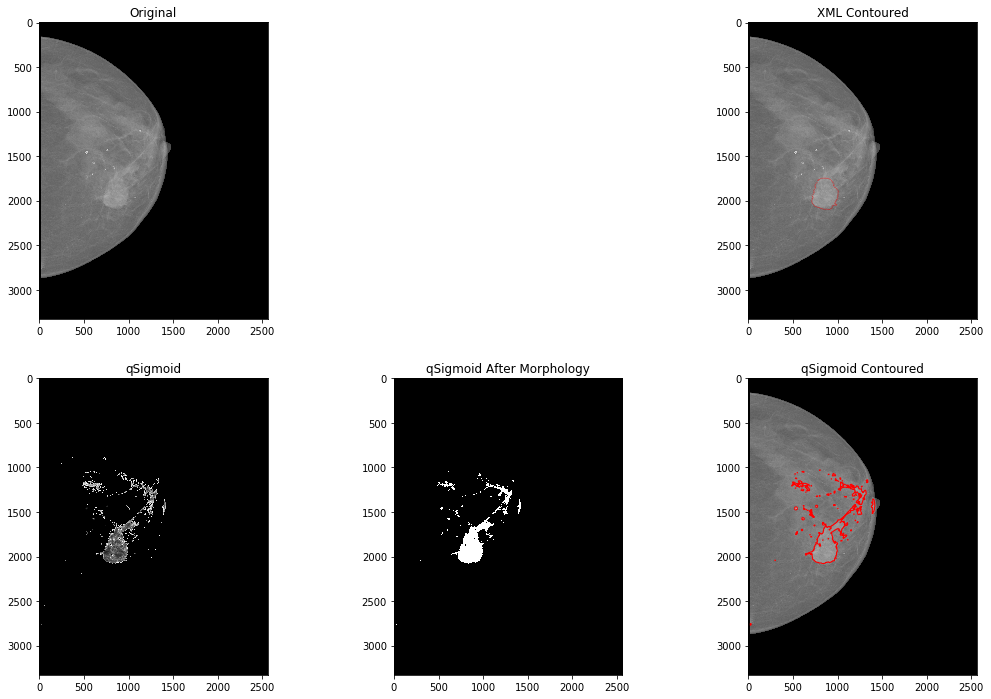

In [8]:
image, image_xml, close_img, image_qSigmoid = makeSegmentation(all_files[idx])
plotSegmentation(image, image_xml, close_img, image_qSigmoid)

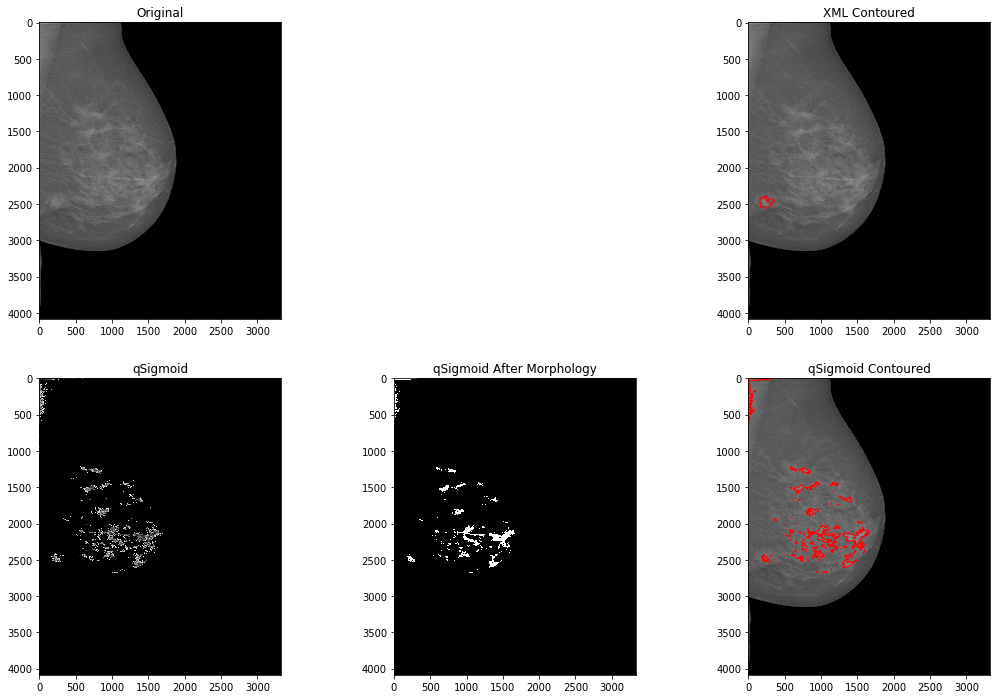

In [9]:
image, image_xml, close_img, image_qSigmoid = makeSegmentation(all_files[50])
plotSegmentation(image, image_xml, close_img, image_qSigmoid)

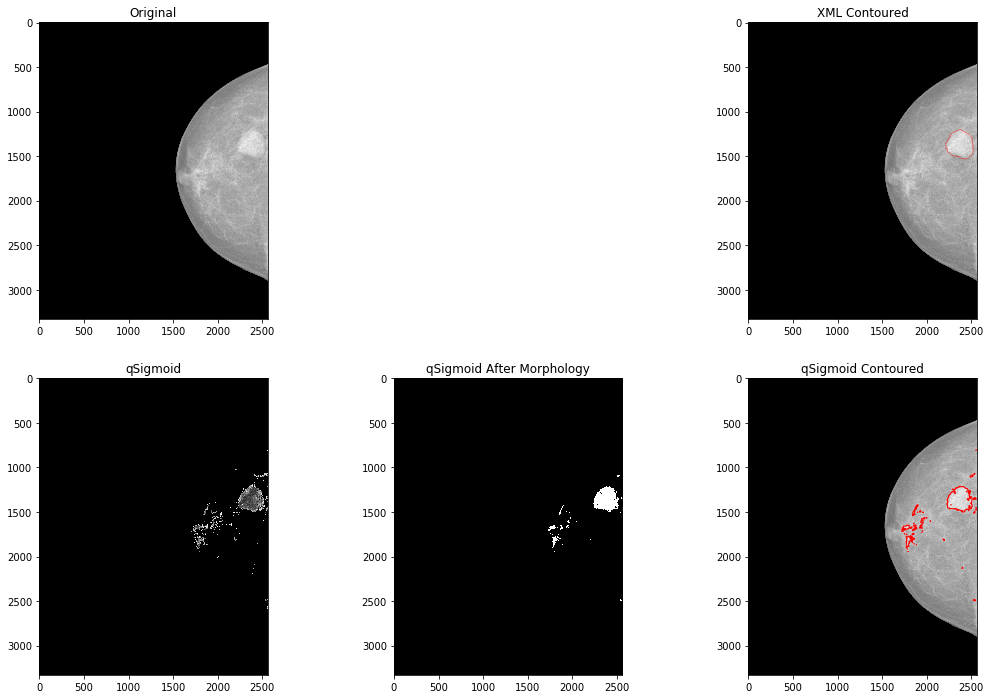

In [10]:
image, image_xml, close_img, image_qSigmoid = makeSegmentation(all_files[idx+2])
plotSegmentation(image, image_xml, close_img, image_qSigmoid)